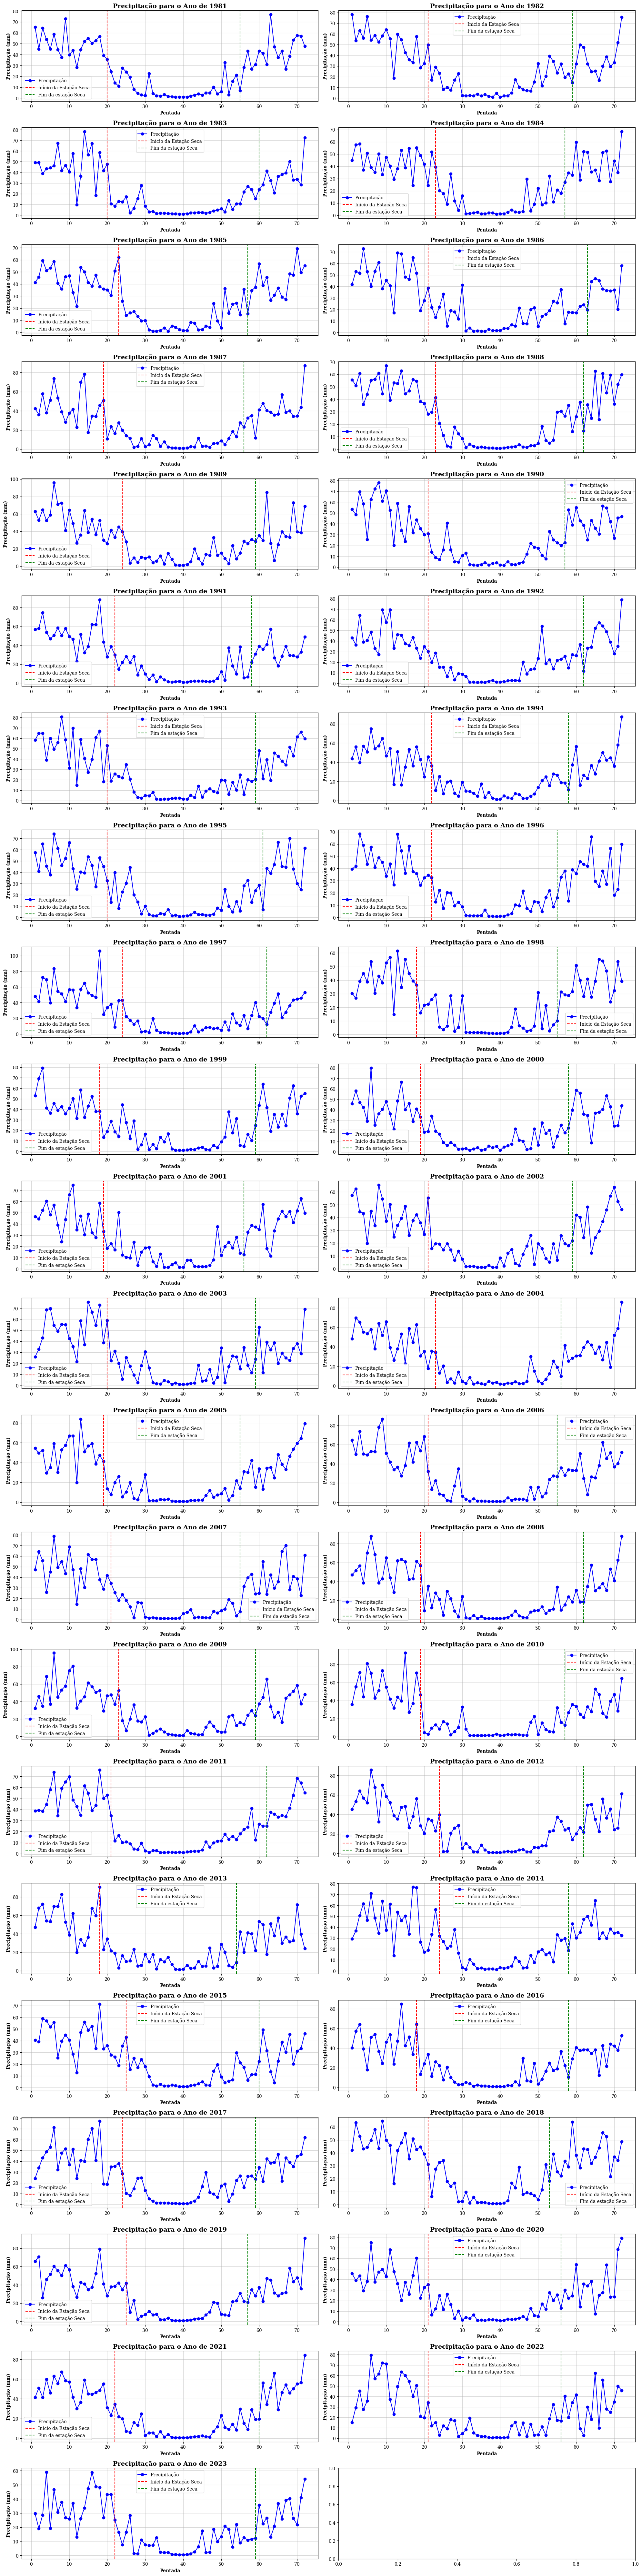

     Ano  Pentada_Início_Seca  Pentada_Fim_Seca  Duração_Seca
0   1981                   20                55            35
1   1982                   21                59            38
2   1983                   20                60            40
3   1984                   23                57            34
4   1985                   23                57            34
5   1986                   21                63            42
6   1987                   19                56            37
7   1988                   23                62            39
8   1989                   24                59            35
9   1990                   21                57            36
10  1991                   22                58            36
11  1992                   21                62            41
12  1993                   20                59            39
13  1994                   22                58            36
14  1995                   20                61            41
15  1996

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'

# Carregar dados do Excel
amazonia = '/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Dados/Amazonia_pentada_areaDesmatada4.xlsx'
df = pd.read_excel(amazonia)

# Transformar o DataFrame para formato longo (long format)
df_long = pd.melt(df, id_vars=["Pentada"], var_name="Ano", value_name="Precipitação")

# Remover linhas onde "Ano" não seja um número (exemplo: "Média")
df_long = df_long[pd.to_numeric(df_long["Ano"], errors="coerce").notna()]

# Converter a coluna "Ano" para numérico
df_long["Ano"] = pd.to_numeric(df_long["Ano"])

# Converter a coluna "Pentada" para numérico, removendo a palavra "º"
df_long["Pentada"] = df_long["Pentada"].str.replace("º", "").astype(int)

# Filtrar os dados de 1981 a 2023
df_filtered = df_long[(df_long["Ano"] >= 1981) & (df_long["Ano"] <= 2023)]

# Lista para armazenar informações da estação seca e chuvosa
season_info = []

# Loop pelos anos para calcular A(day) e identificar início e fim das estações
for year in range(1981, 2024):  # Ajustado para incluir 2023
    year_data = df_filtered[df_filtered["Ano"] == year].copy()

    if year_data.empty:
        print(f"Ano {year} não possui dados suficientes para cálculo.")
        continue

    # Calcular a média anual diária
    R_mean = year_data["Precipitação"].mean()

    # Calcular A(day) acumulando precipitação e subtraindo a média acumulada
    year_data["A_day"] = year_data["Precipitação"].cumsum() - R_mean * year_data["Pentada"]

    # Identificar os pontos de mudança em A_day (início e fim da estação seca)
    try:
        min_index = year_data["A_day"].idxmin()  # Índice do mínimo de A(day)
        max_index = year_data["A_day"].idxmax()  # Índice do máximo de A(day)

        # Garantir que o início (mínimo) vem antes do fim (máximo)
        if min_index < max_index:
            inicio_seca = year_data.loc[min_index, "Pentada"]
            fim_seca = year_data.loc[max_index, "Pentada"]
        else:
            inicio_seca = year_data.loc[max_index, "Pentada"]
            fim_seca = year_data.loc[min_index, "Pentada"]
    except IndexError:
        print(f"Ano {year} não possui dados suficientes para identificar estação seca.")
        continue

    # Adicionar informações ao dataframe
    season_info.append({
        "Ano": year,
        "Pentada_Início_Seca": inicio_seca,
        "Pentada_Fim_Seca": fim_seca,
        "Duração_Seca": fim_seca - inicio_seca
    })

# Transformar as informações da estação em DataFrame
season_df = pd.DataFrame(season_info)

# Definir o caminho para salvar a imagem
output_path = "/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Resultados/AreaDesmatada4_analise.pdf"

# Plotar gráficos para visualizar precipitação e A(day)
fig, axes = plt.subplots(nrows=22, ncols=2, figsize=(20, 80))  # Relacao de tamanho, por quantidade de graficos plotados 
axes = axes.flatten()

for i, year in enumerate(range(1981, 2024)):  # Ajustado para 2023
    ax = axes[i]
    year_data = df_filtered[df_filtered["Ano"] == year]

    if year_data.empty:
        ax.set_title(f"Dados faltantes - {year}")
        continue

    # Plotar a precipitação
    ax.plot(year_data["Pentada"], year_data["Precipitação"], label="Precipitação", marker='o', color='blue')

    # Verificar se a coluna A_day existe antes de plotar
    if "A_day" in year_data.columns:
        # Plotar A(day)
        ax.plot(year_data["Pentada"], year_data["A_day"], label="A(day)", color="red", linestyle="--")
    else:
        ax.set_title(f"A coluna A_day não foi criada - {year}")
    
    # Marcar início e fim da estação seca
    dry_year = season_df[season_df["Ano"] == year]
    if not dry_year.empty:
        ax.axvline(x=dry_year["Pentada_Início_Seca"].values[0], color="red", linestyle="--", label="Início da Estação Seca")
        ax.axvline(x=dry_year["Pentada_Fim_Seca"].values[0], color="green", linestyle="--", label="Fim da estação Seca")

    # Configurações do gráfico
    ax.set_title(f"Precipitação para o Ano de {year}", fontweight='bold', fontsize=14)
    ax.set_xlabel("Pentada", fontweight='bold')
    ax.set_ylabel("Precipitação (mm)",  fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.5)

# Ajustar layout e salvar o gráfico em PDF
plt.tight_layout()
plt.savefig(output_path, format='pdf')  # Salva o gráfico como um PDF
plt.show()


# Exibir as informações da estação seca
print(season_df)


In [2]:
# Cálculos estatísticos sobre a duração da estação seca
def analyze_season_data(season_df):
    # Duração média da estação seca
    mean_duration = season_df["Duração_Seca"].mean()

    # Duração mínima e máxima
    min_duration = season_df["Duração_Seca"].min()
    max_duration = season_df["Duração_Seca"].max()

    # Ano com menor e maior duração
    min_year = season_df.loc[season_df["Duração_Seca"].idxmin(), "Ano"]
    max_year = season_df.loc[season_df["Duração_Seca"].idxmax(), "Ano"]

    # Aumento percentual da duração ao longo dos anos
    initial_duration = season_df.iloc[0]["Duração_Seca"]
    final_duration = season_df.iloc[-1]["Duração_Seca"]
    percentage_change = ((final_duration - initial_duration) / initial_duration) * 100

    # Exibir resultados no terminal
    print("\n--- Análise da Duração da Estação Seca ---")
    print(f"Duração Média (pentadas): {mean_duration:.2f}")
    print(f"Duração Mínima (pentadas): {min_duration} (Ano: {min_year})")
    print(f"Duração Máxima (pentadas): {max_duration} (Ano: {max_year})")
    print(f"Aumento Percentual ao longo dos anos: {percentage_change:.2f}%\n")

    # Retornar os resultados (caso precise usá-los depois)
    return {
        "Duração Média (pentadas)": mean_duration,
        "Duração Mínima (pentadas)": min_duration,
        "Ano Mínimo": min_year,
        "Duração Máxima (pentadas)": max_duration,
        "Ano Máximo": max_year,
        "Aumento Percentual (%)": percentage_change
    }

# Realizar análises e exibir no terminal
analysis_results = analyze_season_data(season_df)




--- Análise da Duração da Estação Seca ---
Duração Média (pentadas): 36.91
Duração Mínima (pentadas): 32 (Ano: 2018)
Duração Máxima (pentadas): 43 (Ano: 2008)
Aumento Percentual ao longo dos anos: 5.71%



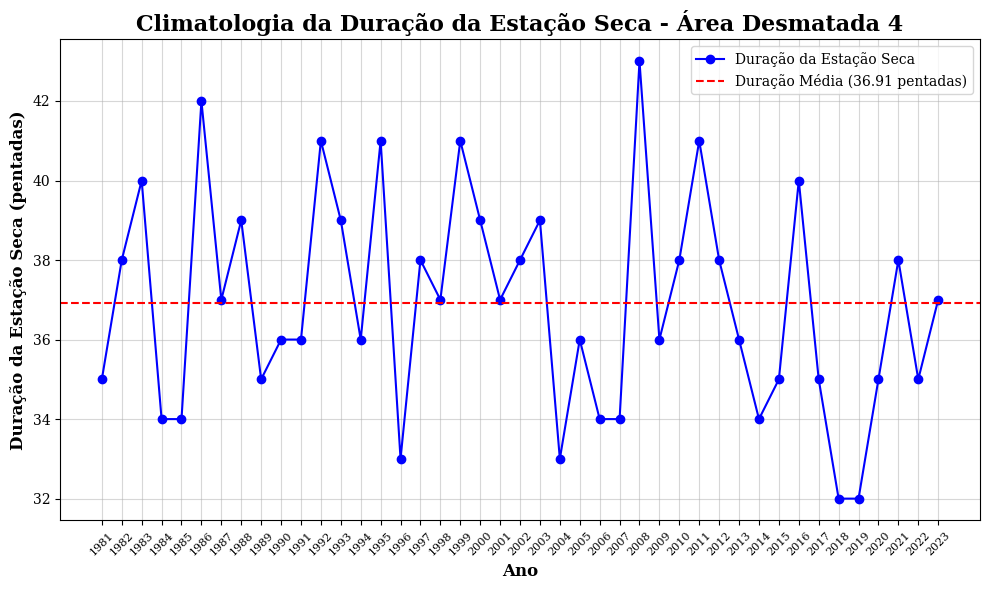

In [6]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico
def plot_dry_season_duration(season_df):
    # Cálculo da duração média
    mean_duration = season_df["Duração_Seca"].mean()

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(season_df["Ano"], season_df["Duração_Seca"], label="Duração da Estação Seca",  color='blue', marker='o')
    plt.axhline(mean_duration, color='red', linestyle='--', label=f"Duração Média ({mean_duration:.2f} pentadas)")

    # Configurar título e rótulos
    plt.title("Climatologia da Duração da Estação Seca - Área Desmatada 4", fontsize=16, fontweight='bold')
    plt.xlabel("Ano", fontsize=12, fontweight='bold')
    plt.ylabel("Duração da Estação Seca (pentadas)", fontsize=12, fontweight='bold')
    plt.xticks(season_df["Ano"], rotation=45, fontsize=8)
    plt.grid(alpha=0.5)

    # Legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

# Chamar a função para plotar
plot_dry_season_duration(season_df)


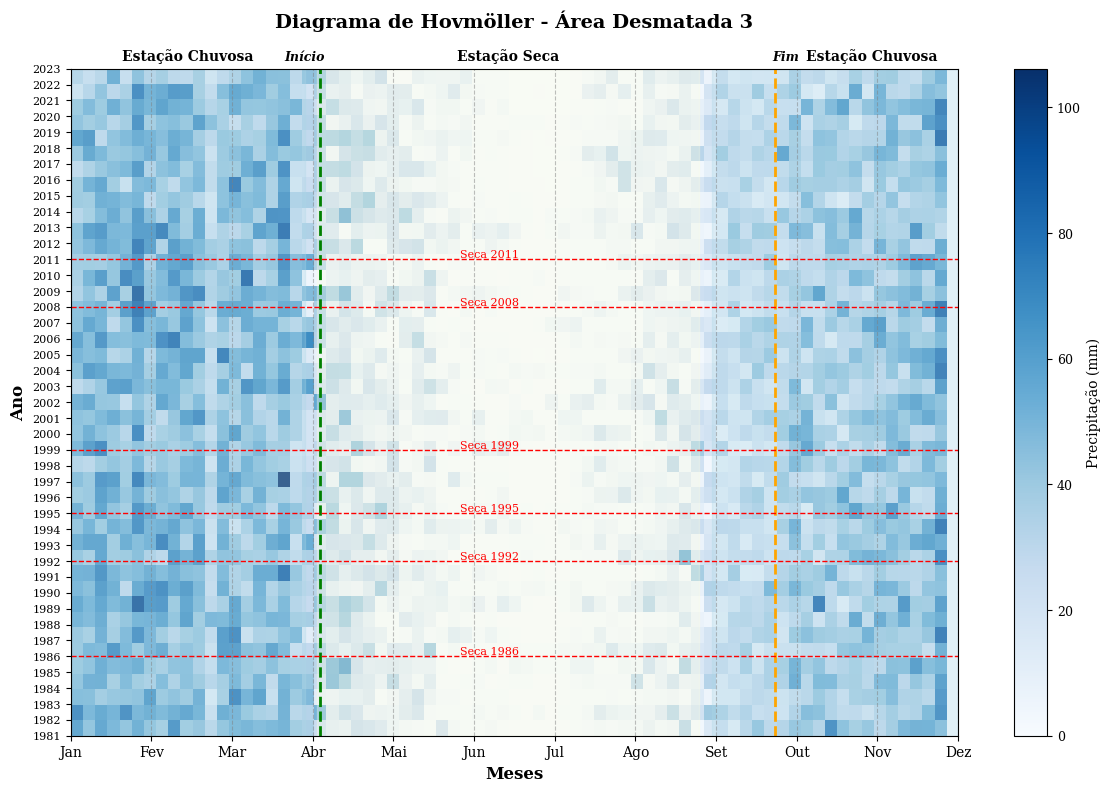

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Dados necessários (simulados)
anos = season_df["Ano"]
inicio_seca = season_df["Pentada_Início_Seca"]
fim_seca = season_df["Pentada_Fim_Seca"]

duracao_seca = fim_seca - inicio_seca

# Criar matriz para o diagrama de Hovmöller usando precipitação (valores simulados para exemplo)
hovmoller_matrix = np.zeros((len(anos), 73))  # 73 pentadas em um ano

# Preenchendo a matriz com dados de precipitação
for i, year in enumerate(anos):
    year_data = df_filtered[df_filtered["Ano"] == year]
    for pentada in year_data["Pentada"]:
        hovmoller_matrix[i, pentada - 1] = year_data.loc[year_data["Pentada"] == pentada, "Precipitação"].values[0]

# Calcular os valores médios de início e fim da estação seca
inicio_seca_medio = inicio_seca.mean()
fim_seca_medio = fim_seca.mean()

# Identificar os anos com maior duração da estação seca
top_duracao_indices = duracao_seca.nlargest(6).index
seca_anos = anos[top_duracao_indices]
seca_pentadas = [35] * len(seca_anos)  # Exemplo: linha em pentada 35

# Configurações do gráfico
plt.figure(figsize=(12, 8))
plt.imshow(
    hovmoller_matrix,
    aspect="auto",
    cmap="Blues",  # Gradiente de azul
    origin="lower",
    extent=[1, 73, anos.min(), anos.max()],
)

# Adicionando áreas para estações seca e chuvosa
plt.axvspan(1, 20, color="lightblue", alpha=0.3)
plt.axvspan(21, 52, color="lightyellow", alpha=0.3)
plt.axvspan(53, 73, color="lightblue", alpha=0.3)

# Adicionar texto para identificar as estações
plt.text(10.5, anos.max() + 0.5, "Estação Chuvosa", fontsize=10, ha="center", fontweight="bold")
plt.text(36.5, anos.max() + 0.5, "Estação Seca", fontsize=10, ha="center", fontweight="bold")
plt.text(66, anos.max() + 0.5, "Estação Chuvosa", fontsize=10, ha="center", fontweight="bold")
plt.text(20, anos.max() + 0.5, "Início", fontsize=9, ha="center", fontweight="bold", style="italic")
plt.text(59, anos.max() + 0.5, "Fim", fontsize=9, ha="center", fontweight="bold", style="italic")

# Adicionar linhas tracejadas para o início e fim médio da estação seca
plt.axvline(x=inicio_seca_medio, color="green", linestyle="--", linewidth=2, label="Início Médio da Estação Seca")
plt.axvline(x=fim_seca_medio, color="orange", linestyle="--", linewidth=2, label="Fim Médio da Estação Seca")

# Marcar eventos de seca com linhas e anotações
for ano, pentada in zip(seca_anos, seca_pentadas):
    plt.axhline(y=ano, color="red", linestyle="--", linewidth=1)
    plt.text(
        pentada,
        ano + 0.1,
        f"Seca {ano}",
        color="red",
        fontsize=8,
        ha="center",
        #bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
    )

# Barra de cores e rótulos
cbar = plt.colorbar(label="Precipitação (mm)")
cbar.ax.tick_params(labelsize=9)
plt.title(
    "Diagrama de Hovmöller - Área Desmatada 3",
    fontsize=14,
    fontweight="bold",
    y=1.05
)
plt.xlabel("Meses", fontsize=12, fontweight="bold")
plt.ylabel("Ano", fontsize=12, fontweight="bold")
plt.xticks(ticks=np.linspace(1, 73, num=12), labels=["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"], fontsize=10)
#plt.yticks(ticks=anos, labels=anos, fontsize=10)
plt.yticks(ticks=anos, labels=anos, fontsize=8)

plt.grid(axis="x", color="gray", linestyle="--", alpha=0.5)

# Ajustar layout e mostrar
plt.tight_layout()
plt.show()



--- Análise de Regressão Linear ---
Equação da linha de tendência: Duração = -0.05 * Ano + 127.60
Inclinação (m): -0.05
Coeficiente de determinação (R²): 0.04


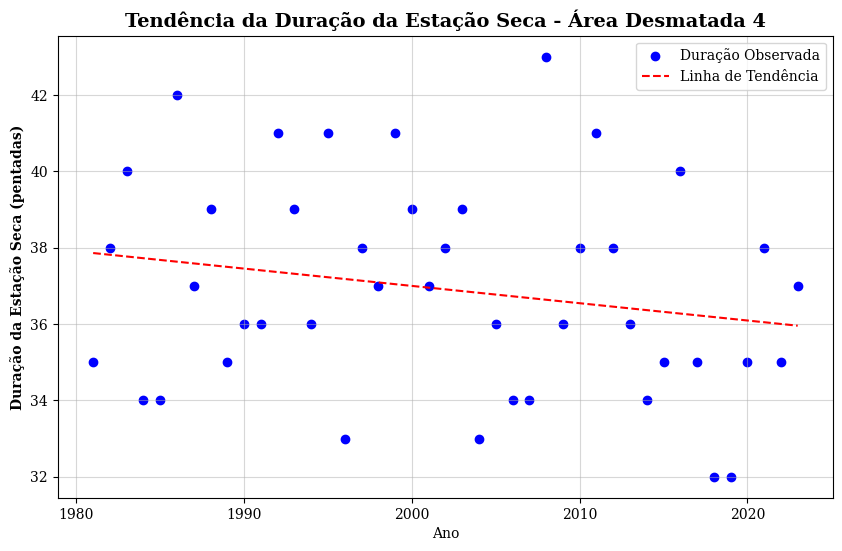

In [8]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Dados para análise
anos = season_df["Ano"]
duracao_seca = season_df["Duração_Seca"]

# Ajustar uma regressão linear (y = mx + b)
X = sm.add_constant(anos)  # Adiciona a constante (intercepto)
model = sm.OLS(duracao_seca, X).fit()  # Ajusta o modelo de regressão
trend_line = model.predict(X)  # Calcula a linha de tendência

# Coeficientes da regressão
coef_angular = model.params[1]  # Inclinação (m)
coef_intercepto = model.params[0]  # Intercepto (b)
r_squared = model.rsquared  # Coeficiente de determinação (qualidade do ajuste)

# Exibir resultados
print("\n--- Análise de Regressão Linear ---")
print(f"Equação da linha de tendência: Duração = {coef_angular:.2f} * Ano + {coef_intercepto:.2f}")
print(f"Inclinação (m): {coef_angular:.2f}")
print(f"Coeficiente de determinação (R²): {r_squared:.2f}")

# Criar um DataFrame com os resultados para exportação
resultados = pd.DataFrame({
    "Ano": anos,
    "Duração Observada": duracao_seca,
    "Linha de Tendência": trend_line
})

# Salvar os dados no Excel
resultados.to_excel("dados_analise_area_preservada3.xlsx", index=False)

# Plotar os dados e a linha de tendência
plt.figure(figsize=(10, 6))
plt.scatter(anos, duracao_seca, color='blue', label="Duração Observada")
plt.plot(anos, trend_line, color='red', linestyle='--', label="Linha de Tendência")
plt.title("Tendência da Duração da Estação Seca - Área Desmatada 4", fontweight='bold', fontsize=14)
plt.xlabel("Ano")
plt.ylabel("Duração da Estação Seca (pentadas)", fontweight='bold')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import statsmodels.api as sm

rcParams['font.family'] = 'serif'

# Carregar dados do Excel
amazonia = '/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Dados/Amazonia_pentada_areaDesmatada4.xlsx'
df = pd.read_excel(amazonia)

# Transformar o DataFrame para formato longo (long format)
df_long = pd.melt(df, id_vars=["Pentada"], var_name="Ano", value_name="Precipitação")

# Remover linhas onde "Ano" não seja um número (exemplo: "Média")
df_long = df_long[pd.to_numeric(df_long["Ano"], errors="coerce").notna()]

# Converter a coluna "Ano" para numérico
df_long["Ano"] = pd.to_numeric(df_long["Ano"])

# Converter a coluna "Pentada" para numérico, removendo a palavra "º"
df_long["Pentada"] = df_long["Pentada"].str.replace("º", "").astype(int)

# Filtrar os dados de 1981 a 2023
df_filtered = df_long[(df_long["Ano"] >= 1981) & (df_long["Ano"] <= 2023)]

# Criar precipitation_df baseado nos dados filtrados
precipitation_df = df_filtered.groupby("Ano")["Precipitação"].sum().reset_index()
precipitation_df.rename(columns={"Precipitação": "Total_Precipitação"}, inplace=True)

# Função para análise de precipitação
def analyze_precipitation_data(precipitation_df):
    # Precipitação média anual
    mean_precipitation = precipitation_df["Total_Precipitação"].mean()

    # Precipitação mínima e máxima
    min_precipitation = precipitation_df["Total_Precipitação"].min()
    max_precipitation = precipitation_df["Total_Precipitação"].max()

    # Ano com menor e maior precipitação
    min_year = precipitation_df.loc[precipitation_df["Total_Precipitação"].idxmin(), "Ano"]
    max_year = precipitation_df.loc[precipitation_df["Total_Precipitação"].idxmax(), "Ano"]

    # Aumento percentual da precipitação ao longo dos anos
    initial_precipitation = precipitation_df.iloc[0]["Total_Precipitação"]
    final_precipitation = precipitation_df.iloc[-1]["Total_Precipitação"]
    percentage_change = ((final_precipitation - initial_precipitation) / initial_precipitation) * 100

    # Exibir resultados no terminal
    print("\n--- Análise da Precipitação Anual Área Desmatada 4 ---")
    print(f"Precipitação Média Anual (mm): {mean_precipitation:.2f}")
    print(f"Precipitação Mínima Anual (mm): {min_precipitation} (Ano: {min_year})")
    print(f"Precipitação Máxima Anual (mm): {max_precipitation} (Ano: {max_year})")
    print(f"Aumento Percentual ao longo dos anos: {percentage_change:.2f}%\n")

    # Retornar os resultados
    return {
        "Precipitação Média Anual (mm)": mean_precipitation,
        "Precipitação Mínima Anual (mm)": min_precipitation,
        "Ano Mínimo": min_year,
        "Precipitação Máxima Anual (mm)": max_precipitation,
        "Ano Máximo": max_year,
        "Aumento Percentual (%)": percentage_change
    }

# Realizar a análise de precipitação
precipitation_analysis = analyze_precipitation_data(precipitation_df)

# Exibir o DataFrame de resultados
print(precipitation_analysis)


--- Análise da Precipitação Anual Área Desmatada 4 ---
Precipitação Média Anual (mm): 1924.10
Precipitação Mínima Anual (mm): 1501.419452480488 (Ano: 2023)
Precipitação Máxima Anual (mm): 2166.6808695963905 (Ano: 1989)
Aumento Percentual ao longo dos anos: -25.52%

{'Precipitação Média Anual (mm)': 1924.097106226936, 'Precipitação Mínima Anual (mm)': 1501.419452480488, 'Ano Mínimo': 2023, 'Precipitação Máxima Anual (mm)': 2166.6808695963905, 'Ano Máximo': 1989, 'Aumento Percentual (%)': -25.521380492778327}


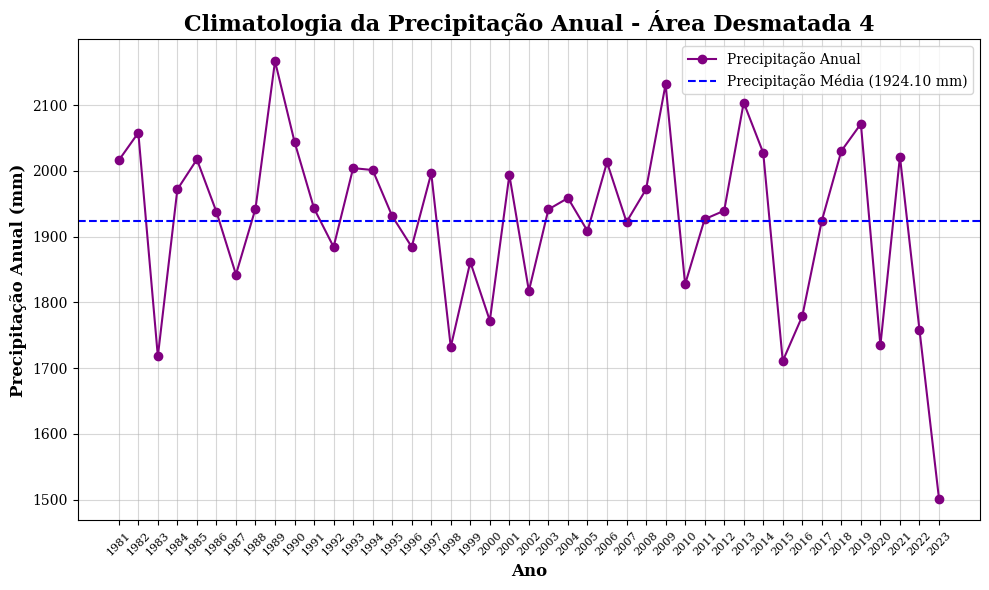

In [10]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico
def plot_precipitation_trend(precipitation_df):
    # Cálculo da precipitação média anual
    mean_precipitation = precipitation_df["Total_Precipitação"].mean()

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(precipitation_df["Ano"], precipitation_df["Total_Precipitação"], label="Precipitação Anual", color='purple', marker='o')
    plt.axhline(mean_precipitation, color='blue', linestyle='--', label=f"Precipitação Média ({mean_precipitation:.2f} mm)")

    # Configurar título e rótulos
    plt.title("Climatologia da Precipitação Anual - Área Desmatada 4", fontsize=16, fontweight='bold')
    plt.xlabel("Ano", fontsize=12, fontweight='bold')
    plt.ylabel("Precipitação Anual (mm)", fontsize=12, fontweight='bold')
    plt.xticks(precipitation_df["Ano"], rotation=45, fontsize=8)
    plt.grid(alpha=0.5)

    # Legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

# Chamar a função para plotar
plot_precipitation_trend(precipitation_df)

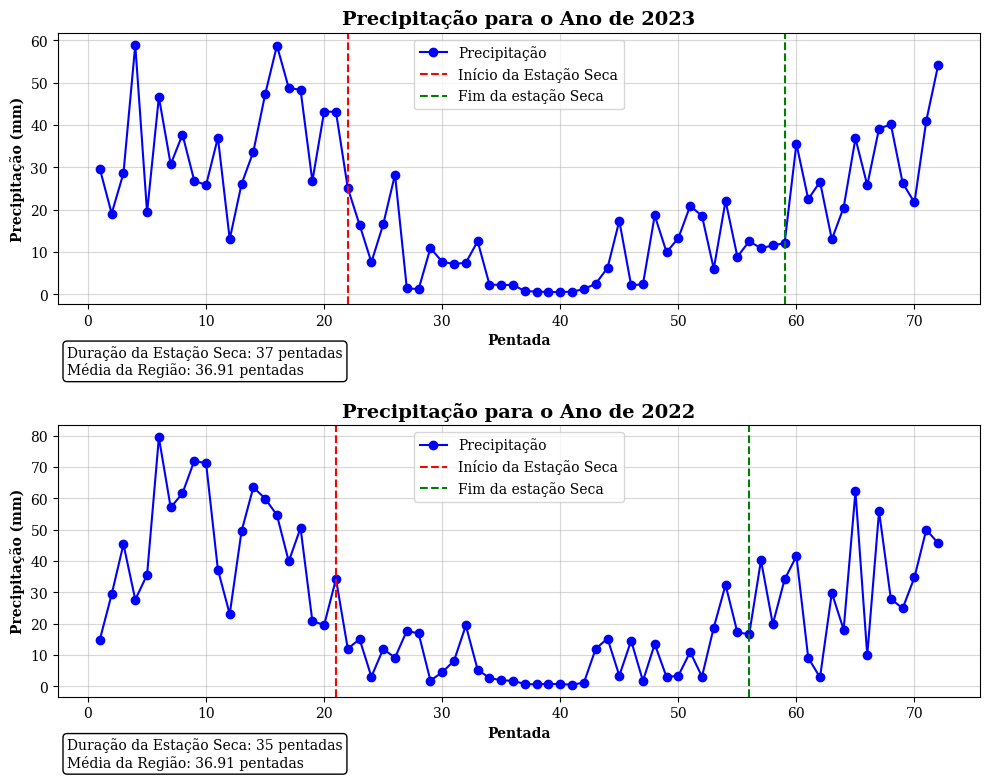

     Ano  Pentada_Início_Seca  Pentada_Fim_Seca  Duração_Seca
0   1981                   20                55            35
1   1982                   21                59            38
2   1983                   20                60            40
3   1984                   23                57            34
4   1985                   23                57            34
5   1986                   21                63            42
6   1987                   19                56            37
7   1988                   23                62            39
8   1989                   24                59            35
9   1990                   21                57            36
10  1991                   22                58            36
11  1992                   21                62            41
12  1993                   20                59            39
13  1994                   22                58            36
14  1995                   20                61            41
15  1996

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'

# Carregar dados do Excel
amazonia = '/home/talita/Documentos/calculo_climatologia/estudoEstacaoSeca/Dados/Amazonia_pentada_areaDesmatada4.xlsx'
df = pd.read_excel(amazonia)

# Transformar o DataFrame para formato longo (long format)
df_long = pd.melt(df, id_vars=["Pentada"], var_name="Ano", value_name="Precipitação")

# Remover linhas onde "Ano" não seja um número (exemplo: "Média")
df_long = df_long[pd.to_numeric(df_long["Ano"], errors="coerce").notna()]

# Converter a coluna "Ano" para numérico
df_long["Ano"] = pd.to_numeric(df_long["Ano"])

# Converter a coluna "Pentada" para numérico, removendo a palavra "º"
df_long["Pentada"] = df_long["Pentada"].str.replace("º", "").astype(int)

# Filtrar os dados de 1981 a 2023
df_filtered = df_long[(df_long["Ano"] >= 1981) & (df_long["Ano"] <= 2023)]

# Lista para armazenar informações da estação seca e chuvosa
season_info = []

# Loop pelos anos para calcular A(day) e identificar início e fim das estações
for year in range(1981, 2024):  # Ajustado para incluir 2023
    year_data = df_filtered[df_filtered["Ano"] == year].copy()

    if year_data.empty:
        print(f"Ano {year} não possui dados suficientes para cálculo.")
        continue

    # Calcular a média anual diária
    R_mean = year_data["Precipitação"].mean()

    # Calcular A(day) acumulando precipitação e subtraindo a média acumulada
    year_data["A_day"] = year_data["Precipitação"].cumsum() - R_mean * year_data["Pentada"]

    # Identificar os pontos de mudança em A_day (início e fim da estação seca)
    try:
        min_index = year_data["A_day"].idxmin()  # Índice do mínimo de A(day)
        max_index = year_data["A_day"].idxmax()  # Índice do máximo de A(day)

        # Garantir que o início (mínimo) vem antes do fim (máximo)
        if min_index < max_index:
            inicio_seca = year_data.loc[min_index, "Pentada"]
            fim_seca = year_data.loc[max_index, "Pentada"]
        else:
            inicio_seca = year_data.loc[max_index, "Pentada"]
            fim_seca = year_data.loc[min_index, "Pentada"]
    except IndexError:
        print(f"Ano {year} não possui dados suficientes para identificar estação seca.")
        continue

    # Adicionar informações ao dataframe
    season_info.append({
        "Ano": year,
        "Pentada_Início_Seca": inicio_seca,
        "Pentada_Fim_Seca": fim_seca,
        "Duração_Seca": fim_seca - inicio_seca
    })

# Transformar as informações da estação em DataFrame
season_df = pd.DataFrame(season_info)

# Cálculo da duração média da estação seca da região
duracao_media_seca = season_df["Duração_Seca"].mean()

# Filtrar apenas os anos desejados (2014, 2017, 1982)
anos_desejados = [2023, 2022]
df_filtered_selected = df_filtered[df_filtered["Ano"].isin(anos_desejados)]

# Plotar gráficos apenas para os anos selecionados
fig, axes = plt.subplots(nrows=len(anos_desejados), ncols=1, figsize=(10, 8))
axes = axes.flatten()

for i, year in enumerate(anos_desejados):
    ax = axes[i]
    year_data = df_filtered[df_filtered["Ano"] == year]

    if year_data.empty:
        ax.set_title(f"Dados faltantes - {year}")
        continue

    # Plotar a precipitação
    ax.plot(year_data["Pentada"], year_data["Precipitação"], label="Precipitação", marker='o', color='blue')

    # Verificar se a coluna A_day existe antes de plotar
    if "A_day" in year_data.columns:
        # Plotar A(day)
        ax.plot(year_data["Pentada"], year_data["A_day"], label="A(day)", color="red", linestyle="--")
    else:
        ax.set_title(f"A coluna A_day não foi criada - {year}")
    
    # Marcar início e fim da estação seca
    dry_year = season_df[season_df["Ano"] == year]
    if not dry_year.empty:
        ax.axvline(x=dry_year["Pentada_Início_Seca"].values[0], color="red", linestyle="--", label="Início da Estação Seca")
        ax.axvline(x=dry_year["Pentada_Fim_Seca"].values[0], color="green", linestyle="--", label="Fim da estação Seca")

        # Adicionar legenda com duração da estação seca
        ax.text(
            0.01, -0.15,
            f"Duração da Estação Seca: {dry_year['Duração_Seca'].values[0]} pentadas\nMédia da Região: {duracao_media_seca:.2f} pentadas",
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
        )

    # Configurações do gráfico
    ax.set_title(f"Precipitação para o Ano de {year}", fontweight='bold', fontsize=14)
    ax.set_xlabel("Pentada", fontweight='bold')
    ax.set_ylabel("Precipitação (mm)", fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.5)

# Ajustar layout e aumentar o espaçamento entre os gráficos
plt.subplots_adjust(hspace=41)  # Aumentando o espaçamento entre os gráficos

# Exibir os gráficos
plt.tight_layout()
plt.show()

# Exibir as informações da estação seca
print(season_df)


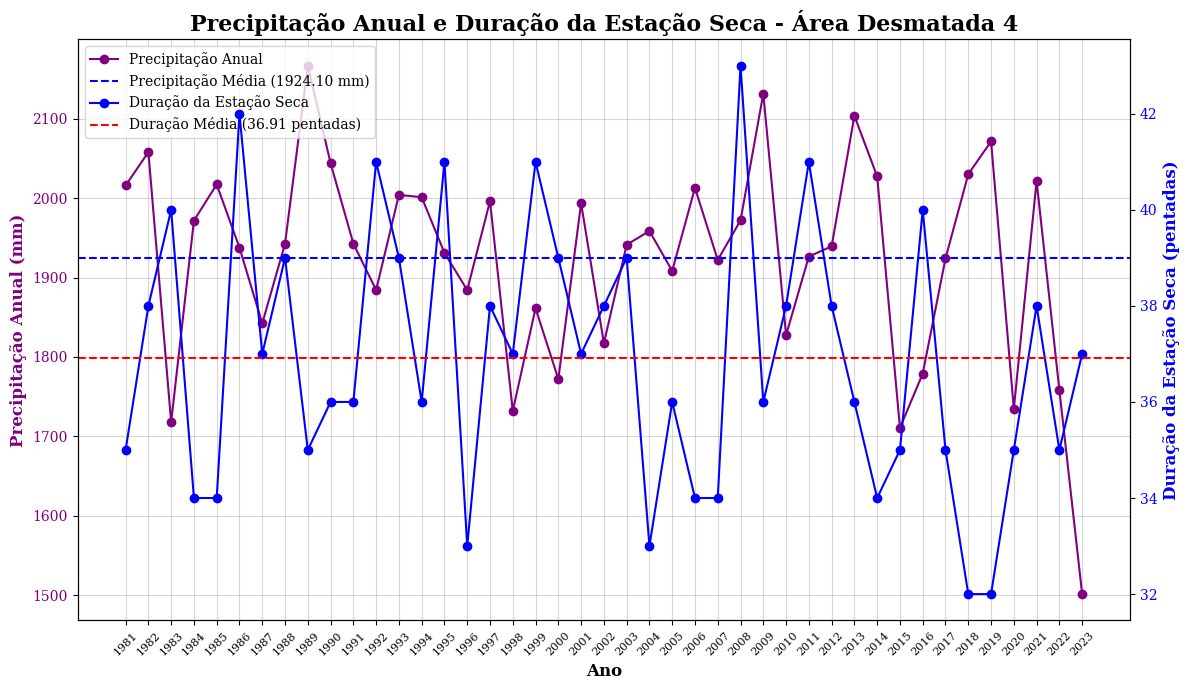

In [13]:
import matplotlib.pyplot as plt

# Função para combinar os gráficos de precipitação e duração da estação seca
def plot_combined_trend(precipitation_df, season_df):
    # Criar a figura e os eixos
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Gráfico da precipitação (eixo esquerdo)
    ax1.plot(
        precipitation_df["Ano"], precipitation_df["Total_Precipitação"], 
        label="Precipitação Anual", color='purple', marker='o'
    )
    mean_precipitation = precipitation_df["Total_Precipitação"].mean()
    ax1.axhline(mean_precipitation, color='blue', linestyle='--', label=f"Precipitação Média ({mean_precipitation:.2f} mm)")
    ax1.set_xlabel("Ano", fontsize=12, fontweight='bold')
    ax1.set_ylabel("Precipitação Anual (mm)", fontsize=12, fontweight='bold', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')
    ax1.grid(alpha=0.5)

    # Gráfico da duração da estação seca (eixo direito)
    ax2 = ax1.twinx()
    ax2.plot(
        season_df["Ano"], season_df["Duração_Seca"], 
        label="Duração da Estação Seca", color='blue', marker='o'
    )
    mean_duration = season_df["Duração_Seca"].mean()
    ax2.axhline(mean_duration, color='red', linestyle='--', label=f"Duração Média ({mean_duration:.2f} pentadas)")
    ax2.set_ylabel("Duração da Estação Seca (pentadas)", fontsize=12, fontweight='bold', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Configurar ticks do eixo x para mostrar todos os anos
    all_years = sorted(precipitation_df["Ano"].unique())  # Listar todos os anos únicos
    ax1.set_xticks(all_years)  # Definir os anos como ticks no eixo x
    ax1.set_xticklabels(all_years, rotation=45, fontsize=8)  # Rotacionar os anos para melhor legibilidade

    # Combinar legendas dos dois eixos
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", fontsize=10)

    # Título do gráfico
    plt.title("Precipitação Anual e Duração da Estação Seca - Área Desmatada 4", fontsize=16, fontweight='bold')

    # Ajustar layout
    plt.tight_layout()

    # Mostrar o gráfico
    plt.show()

# Chamar a função para plotar os gráficos combinados
plot_combined_trend(precipitation_df, season_df)



--- Precipitação Média Anual ---
Ano
1981    2015.906662
1982    2057.906866
1983    1717.855436
1984    1971.726484
1985    2017.288807
1986    1937.586317
1987    1842.283452
1988    1942.523019
1989    2166.680870
1990    2043.986608
1991    1942.674777
1992    1884.229838
1993    2004.093065
1994    2001.156794
1995    1931.078283
1996    1884.210052
1997    1996.226273
1998    1732.012329
1999    1861.357785
2000    1772.110204
2001    1993.627508
2002    1817.312414
2003    1941.294605
2004    1958.569189
2005    1908.391085
2006    2012.922982
2007    1922.132284
2008    1971.906132
2009    2131.642209
2010    1827.466361
2011    1926.457873
2012    1939.293507
2013    2103.752697
2014    2027.284030
2015    1710.749575
2016    1779.003275
2017    1924.028057
2018    2030.134277
2019    2071.392889
2020    1734.577168
2021    2021.651845
2022    1758.272232
2023    1501.419452
Name: Total_Precipitação, dtype: float64


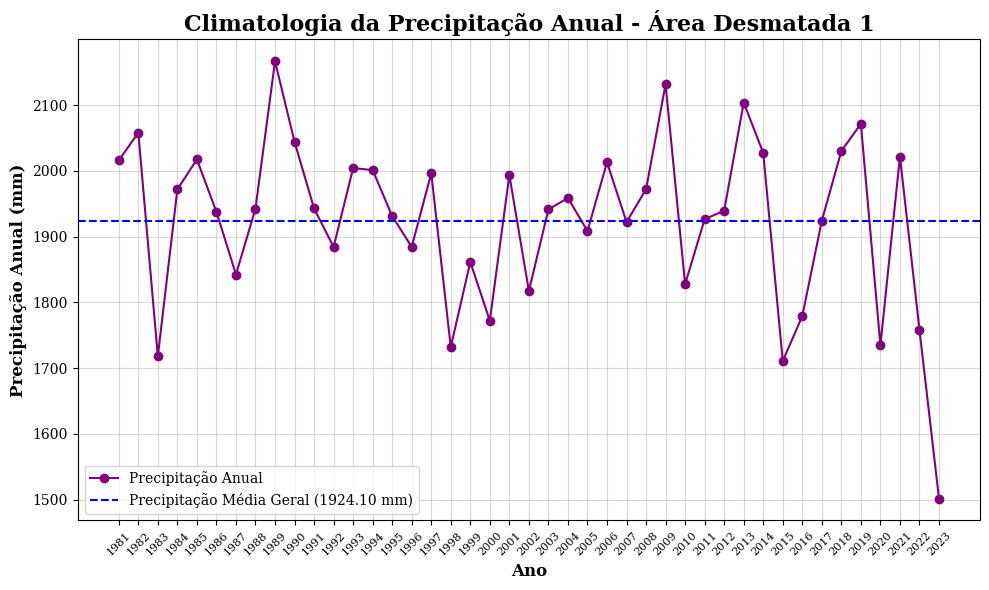

In [12]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico e calcular a precipitação média anual
def plot_precipitation_trend(precipitation_df):
    # Cálculo da precipitação média anual por ano
    yearly_mean_precipitation = precipitation_df.groupby("Ano")["Total_Precipitação"].mean()

    # Exibir a precipitação média anual no terminal
    print("\n--- Precipitação Média Anual ---")
    print(yearly_mean_precipitation)

    # Criar o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(precipitation_df["Ano"], precipitation_df["Total_Precipitação"], label="Precipitação Anual", color='purple', marker='o')
    plt.axhline(precipitation_df["Total_Precipitação"].mean(), color='blue', linestyle='--', label=f"Precipitação Média Geral ({precipitation_df['Total_Precipitação'].mean():.2f} mm)")

    # Configurar título e rótulos
    plt.title("Climatologia da Precipitação Anual - Área Desmatada 1", fontsize=16, fontweight='bold')
    plt.xlabel("Ano", fontsize=12, fontweight='bold')
    plt.ylabel("Precipitação Anual (mm)", fontsize=12, fontweight='bold')
    plt.xticks(precipitation_df["Ano"], rotation=45, fontsize=8)
    plt.grid(alpha=0.5)

    # Legenda
    plt.legend()
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

    # Retornar os valores de precipitação média anual
    return yearly_mean_precipitation

# Chamar a função e exibir os resultados
yearly_mean = plot_precipitation_trend(precipitation_df)
